## Hardware information

In [ ]:
!cat /proc/cpuinfo | grep 'model name'

model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz


In [ ]:
!cat /proc/cpuinfo | grep 'cpu cores'

cpu cores	: 1
cpu cores	: 1


In [ ]:
!cat /proc/cpuinfo | grep 'cpu MHz'

cpu MHz		: 3000.000
cpu MHz		: 3000.000
cpu MHz		: 3000.000
cpu MHz		: 1485.873
cpu MHz		: 3000.000
cpu MHz		: 3000.000
cpu MHz		: 3000.000
cpu MHz		: 3000.000


In [ ]:
!lscpu | grep 'Architecture'

Architecture:                       x86_64


In [ ]:
!lscpu | grep 'Thread(s) per core'

Thread(s) per core:                 2


In [ ]:
!lscpu | grep 'Core(s) per socket'

Core(s) per socket:                 4


In [ ]:
!lscpu | grep 'Socket(s)'

Socket(s):                          1


In [ ]:
!cat /proc/meminfo | grep 'MemTotal'

MemTotal:       62745496 kB


In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-b42ad1e9-bc98-7b0f-288a-a11837d8d0ff)


## Install requirements


In [ ]:
!pip install upgrade tensorflow
!pip install -r requirements.txt
!pip install emoji preprocessor sentence_transformers eli5 captum transformers_interpret evaluate transformers[torch] tensorflow
!pip install git+https://github.com/huggingface/accelerate
!pip install() --upgrade transformers

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/util

# Imports and function definitions

In [ ]:
# General purpose
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

# Modeling
import torch
import torch.nn as nn
torch.set_flush_denormal(True)
from transformers import (
    BertForSequenceClassification,
    AdamW,
    BertTokenizer,
    Trainer,
    TrainingArguments
)
from transformers import TrainingArguments, Trainer

# Hugging Face Dataset
from datasets import Dataset

# Model performance evaluation
import evaluate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import traceback
import warnings

# Others
import os
from sklearn.utils import check_random_state

In [ ]:
nltk.download('stopwords')
# Create a set of stop words
stop_words = set(stopwords.words('english'))

In [ ]:
class BertClassifier:
    """
    BERT-based text classifier for sequence classification tasks.

    This class provides functionality to train, evaluate, and use a BERT
    model for text classification tasks. It encapsulates the BERT model
    initialization, tokenization, training, evaluation, and prediction
    processes.

    Methods:
        __compute_metrics: Computes evaluation metrics.
        compute_loss: Computes the loss using Cross Entropy Loss.
        fit: Fine-tune the BERT model using the provided training data.
        predict: Make predictions on input text data using the trained model.
    """

    def __init__(self, training_args, id2label):
        """
        Parameters:
        - training_args (TrainingArguments): Training argumentsfor
          fine-tuning BERT.
        - id2label (dict): Dictionary mapping label IDs to their corresponding
          labels.
        """
        self.model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=17,
            id2label=id2label
        )
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu'
        )
        self.model.to(self.device)
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.training_args = training_args
        self.trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=None,
            eval_dataset=None,
            compute_metrics=None
        )

    def __compute_metrics(self, eval_pred):
        """
        Computes evaluation metrics.

        This method computes evaluation metrics such as accuracy, precision,
        recall, and F1-score based on the provided logits and labels.

        Parameters:
        - eval_pred (tuple): A tuple containing logits and labels.

        Return:
            dict: A dictionary containing the evaluation metrics including:
                - 'accuracy': Accuracy score
                - 'precision': Precision score (macro average)
                - 'recall': Recall score (macro average)
                - 'f1': F1 score (macro average)
        """
        logits, labels = eval_pred
        # probabilities = tf.nn.softmax(logits)
        predictions = np.argmax(logits, axis=1)
        results = {
            'accuracy': accuracy_score(labels, predictions),
            'precision': precision_score(
                labels,
                predictions,
                average='macro',
                zero_division=0
            ),
            'recall': recall_score(
                labels,
                predictions,
                average='macro',
                zero_division=0
            ),
            'f1': f1_score(
                labels,
                predictions,
                average='macro',
                zero_division=0
            )
        }
        return results

    def compute_loss(self, eval_pred):
        """
        Computes the loss using Cross Entropy Loss.

        This method calculates the loss using the Cross Entropy Loss function
        based on the provided logits and labels.

        Parameters:
        - eval_pred (tuple): A tuple containing logits and labels.

        Return:
            torch.Tensor: The computed loss value.
        """
        logits, labels = eval_pred
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)
        return loss

    def fit(self, X_train, y_train, X_test, y_test):
        """
        Fine-tunes the BERT model using the provided training data.

        This method fine-tunes the BERT model using the provided training data
        and evaluates its performance on the provided testing data.

        Parameters:
        - X_train (list): A list of input text data for training.
        - y_train (list): A list of corresponding labels for training.
        - X_test (list): A list of input text data for testing.
        - y_test (list): A list of corresponding labels for testing.
        """
        train_tokens = self.tokenizer(
            X_train,
            truncation=True,
            padding=True,
            return_tensors='pt'
        ).to(self.device)
        train_tokens['labels'] = torch.tensor(y_train).to(self.device)
        train_dataset = Dataset.from_dict(
            {k: v for k, v in train_tokens.items()}
        )

        test_tokens = self.tokenizer(
            X_test,
            truncation=True,
            padding=True,
            return_tensors='pt'
        )
        test_tokens.to(self.device)
        test_tokens['labels'] = torch.tensor(y_test).to(self.device)
        test_dataset = Dataset.from_dict(
            {k: v for k, v in test_tokens.items()}
        )

        self.trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=self.__compute_metrics
        )
        self.trainer.train()

    def predict(self, X):
        """
        Makes predictions on input text data using the trained model.

        This method takes input text data, tokenizes it, and makes predictions
        using the trained BERT model.

        Parameters:
        - X (list): A list of input text data.

        Returns:
            numpy.ndarray: An array of predicted labels.
        """
        test_tokens = self.tokenizer(
            X,
            truncation=True,
            padding=True,
            return_tensors='pt'
        )
        test_tokens.to(self.device)
        test_dataset = Dataset.from_dict(
            {k: v for k, v in test_tokens.items()}
        )
        self.trainer.compute_metrics = self.__compute_metrics
        self.trainer.eval_dataset = test_dataset

        predictions = self.trainer.predict(test_dataset)
        return predictions.predictions

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def plot_confusion_matrix(
    true_labels,
    pred_labels,
    figsize=(20, 10),
    save=False,
    save_path=None
):
    """
    Plots a confusion matrix.

    Parameters:
    - true_labels: Actual labels
    - pred_labels: Predicted labels
    - figsize: Size of the figure (default is (15, 10))
    """
    # Get unique labels
    labels = np.unique(true_labels)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Convert to DataFrame for easier visualization
    cm_df = pd.DataFrame(cm, index=labels + 1, columns=labels + 1)

    # Create a heatmap using seaborn
    plt.figure(figsize=figsize)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Save the plot if save is True
    if save:
        plt.savefig(save_path)

    plt.show()

In [ ]:
def plot_classification_report(
    df_report,
    train_data,
    figsize=(15, 10),
    save=False,
    save_path=None
):
    """
    Plots a classification report.

    Parameters:
    - df_report: DataFrame containing the classification report
    - train_data: DataFrame containing the training data
    - figsize: Size of the figure (default is (15, 10))
    """
    # Calculate the frequencies
    frequencies = train_data['label'].value_counts()

    # Create the xticks labels with frequencies
    xticks = (
        [
            f'{label+1} ({frequencies[label]})'
            for label in range(0, 17)
        ]
        + ['macro avg', 'weighted avg']
    )

    df_report.index = df_report.index.astype(str)

    # Plot the classification report
    df_report.plot(
        kind='bar',
        ylim=(0,1),
        rot=90,
        title='Classification Report',
        figsize=figsize
    )

    # Set the xticks
    _ = plt.xticks(range(len(xticks)-1), xticks)

    # Save the plot if save is True
    if save:
        plt.savefig(save_path)

    plt.show()

In [ ]:
def softmax(x):
    """
    Computes the softmax function for an input array.

    Parameters:
    - x (numpy.ndarray): Input array of real numbers.

    Return:
        numpy.ndarray: An array of softmax probabilities corresponding to
        each element in the input array 'x'.
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
def set_training_args():
    """
    Generates training arguments and label mappings for a BERT-based sequence classification model.

    Return:
        tuple: A tuple containing two elements:
            - training_args (TrainingArguments): Training arguments for the
              Trainer object.
            - id2label (dict): Dictionary mapping label indices to Sustainable
              Development Goals (SDGs).
    """
    # Set up model parameters
    # Define the 17 SDGs
    sdgs = [
        'No Poverty',
        'Zero Hunger',
        'Good Health and Well-being',
        'Quality Education',
        'Gender Equality',
        'Clean Water and Sanitation',
        'Affordable and Clean Energy',
        'Decent Work and Economic Growth',
        'Industry, Innovation, and Infrastructure',
        'Reduced Inequality',
        'Sustainable Cities and Communities',
        'Responsible Consumption and Production',
        'Climate Action',
        'Life Below Water',
        'Life on Land',
        'Peace, Justice, and Strong Institutions',
        'Partnerships for the Goals
    ]

    # Create a dictionary to map the SDGs to their respective IDs
    id2label = {}

    for i, sgd in enumerate(sdgs):
        id2label[i] = sgd

    # Set up the training arguments
    training_args = TrainingArguments(
        output_dir=(
            './training_logs/bert-base-uncased-stratified-simplified/'
        ),
        logging_dir=(
            './training_logs/bert-base-uncased-stratified-simplified/logs/'
        ),
        logging_strategy='epoch',
        logging_steps=100,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        learning_rate=5e-6,
        save_strategy='epoch',
        save_steps=100,
        evaluation_strategy='epoch',
        eval_steps=100,
        load_best_model_at_end=True,
        num_train_epochs=10,
    )

    return training_args, id2label

# **Model training**

In [ ]:
"""
Meaning of columns:

original_absract_text: The unprocessed abstract text
preprocessed_abstract_text: The preprocessed abstract text
tokens: The tokenized abstract text after preprocessing
label_count: The number of labels
label: The SDG label
character_count: The number of characters in the unprocessed abstract text
word_count: The number of words in the unprocessed abstract text
token_count: The number of tokens in the tokenized abstract text
"""

# Load data
df = pd.read_csv('original_and_preprocessed.csv', sep=';', encoding='utf-8')
df['label'] = df['label'] - 1 # Adjust labels to start from 0 to 16 because the model expects labels from 0 to 16
df.drop_duplicates(inplace=True)
df.head()

,original_abstract_text,processed_abstract_text,tokens,label,label_count,character_count,word_count,token_count
0,\n In this manuscript we repo...,manuscript report facile synthesis route elect...,"tensor([[ 101, 8356, 3189, 6904, 6895, 2...",6,1307,2550,286,321
1,\n \n Cys...,cystoseira sargassaceae genus marine brown alg...,"tensor([[ 101, 22330, 16033, 20240, 2527, 18...",2,7772,1169,143,155
2,\n Colorectal cancer is one o...,colorectal cancer one common types cancer acco...,"tensor([[ 101, 3609, 22471, 2389, 4456, 2...",2,7772,2254,309,243
3,\n Aims\n Ca...,aims cardiac arrhythmias one important remote ...,"tensor([[ 101, 8704, 15050, 12098, 25032, 22...",2,7772,2561,296,294
4,\n Hesperidin is an abundant ...,hesperidin abundant flavanone cheap byproduct ...,"tensor([[ 101, 2002, 17668, 28173, 2078, 12...",2,7772,1564,224,223


In [ ]:
# Verify the shape of the data
df.shape

(13789, 8)

In [ ]:
# Initialize training arguments
set_training_args()

## **30x train-test run**

In [ ]:
# 30x train-test run

# Ignore warnings
warnings.filterwarnings('ignore')

# Load data resetting the index
X = df['processed_abstract_text'].reset_index(drop=True)
y = df['label'].reset_index(drop=True)

# Will be use to construct a confusion matrix composed of the means of the confusion matrices of each run
total_cm = np.zeros((17, 17))
# List to store the classification reports of each run to create a final report with the mean
classification_reports = []
# Get the unique classes in the entire dataset, will be needed to check if all labels are represented in both training and testing sets
unique_labels = np.unique(y)

equal_counts_list = [] # To check if the

# This code implements a small checkpoint system to avoid losing progress in case of an error
# It will save the results of each run in a separate file, and the iteration number in a checkpoint file
if os.path.exists('checkpoints/checkpoint.txt'): # Check if the checkpoint file exists
    with open('checkpoints/checkpoint.txt', 'r') as f: # If it does, read the iteration number from it
        start_iter = int(f.read())
else:
    start_iter = 0 # If it doesn't, start from 0

# This for loop will run the model 30 times, each time with a different random state
for i in tqdm(range(start_iter, 30), desc='Run', leave=True):
    train_index, test_index = 0, 0 # initialize indices
    X_train, X_test, y_train, y_test = np.array([]), np.array([]), np.array([]), np.array([]) # initiallize empty numpy arrays

    try:
        # Check if the report for this iteration already exists
        if os.path.exists(f'checkpoints/report_{i}.csv'):
            continue # If it does, skip this iteration

        report_df = pd.DataFrame() # Initialize the report DataFrame

        # Stratified shuffled train-test-split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i, stratify=y, shuffle=True)

        # Get unique labels in y_test and y
        unique_test_labels = np.unique(y_test)

        # Because this is an unbalanced data set there might be some train-test-split where not all labels will be represented in both sets
        # The next few lines will make sure at least 1 sample from each label is represented in the test set

        if set(unique_test_labels) != set(unique_labels): # Check if not all labels are represented in the test set
            missing_labels = set(unique_labels) - set(unique_test_labels) # Get the missing labels

            # For each missing label, add samples from the training set to the test set
            for missing_label in missing_labels:

                # Collect the indices of the samples to be moved
                missing_label_indices = y_train[y_train == missing_label].index.tolist()
                # Get the index of the first occurence of the missing label
                missing_label_index = missing_label_indices[0]

                # Add these samples to the test set
                X_test = pd.concat([X_test, X_train.loc[[missing_label_index]]], axis=0)
                y_test = pd.concat([y_test, y_train.loc[[missing_label_index]]], axis=0)

                # Remove these samples from the training set
                X_train = X_train.drop(missing_label_index)
                y_train = y_train.drop(missing_label_index)

        # Initialize and fit the model
        bert_classifier = BertClassifier(training_args, id2label)
        bert_classifier.fit(X_train.tolist(), # The train and test sets need to be converted to lists
                            y_train.tolist(),
                            X_test.tolist(), # The test dataset is for evaluation only, the model will never see this set when training
                            y_test.tolist()
                            )

        # Make predictions
        pred_logits = bert_classifier.predict(X_test.tolist())
        y_pred = np.argmax(pred_logits, axis=1) # Get the predicted labels from logits

        # Get the classification report
        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        # Convert the report to a DataFrame
        report_df = pd.DataFrame(report_dict)
        # Append the report to the list of reports, so later on we can calculate the mean and create a final report
        classification_reports.append(report_df)

        # Update the total confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
        total_cm += cm

        # Used by the checkpoint system
        # Save the results after each run
        with open(f'checkpoints/report_{i}.csv', 'w') as f: # Save the current classification report
            print(f'Saving report {i}...')
            report_df.to_csv(f, sep=';', index_label='Metrics')
        with open(f'checkpoints/total_cm_{i}.csv', 'w') as f: # Save the current confusion matrix
            print(f'Saving confusion matrix {i}...')
            pd.DataFrame(total_cm).to_csv(f, sep=';', index=False)
        with open(f'results/pred_logits_{i}.csv', 'w') as f: # Save the prediction logits
            print(f'Saving prediction logits {i}...')
            pd.DataFrame(pred_logits).to_csv(f, sep=';', index=False)
        # Save the current model weights so we can select the model weights with
        # the best performance at the end of the experimetn
        with open(f'model/model_state_{i}.pt', 'wb') as f:
            print(f'Saving model state {i}...')
            torch.save(bert_classifier.model.state_dict(), f)
        # Save the current iteration number to the checkpoint file
        with open('checkpoints/checkpoint.txt', 'w') as f:
            print(f'Saving checkpoint {i}...')
            f.write(str(i))

    except Exception as e: # If an error occurs, print the error and the traceback
        print(f'Error in run {i}: {e}')
        traceback.print_exc()

# This is the end of the 30x runs
# Now, concatenate the reports and calculate the mean
all_reports = pd.concat(classification_reports, axis=0)
mean_reports = all_reports.groupby(all_reports.index).mean()

# Save concatenated reports for backup
with open('results/all_reports_backup.csv', 'w') as f:
    print('Saving all reports...')
    all_reports.to_csv(f, sep=';', index_label='Metrics')


Run:   0%|          | 0/30 [00:00<?, ?it/s]

Are the counts equal? True


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


In [ ]:
# Calculate the best run to get the best model_state

_all_reports = all_reports

# Calculate the number of metrics per run
total_runs = 30
metrics_per_run = len(_all_reports) // total_runs  # replace 'total_runs' with the actual number of runs

# Create a range from 0 to the number of rows in _all_reports
run_numbers = range(len(_all_reports))

# Convert the range to a DataFrame
run_numbers_df = pd.DataFrame(run_numbers, columns=['run_number'], index=_all_reports.index)

# Divide the run numbers by the number of metrics per run and add 1 to get the run number for each report
run_numbers_df['run_number'] = (run_numbers_df['run_number'] // metrics_per_run) + 1

# Add the run number column to _all_reports
_all_reports = pd.concat([_all_reports, run_numbers_df], axis=1)

# Remove the 'support' rows
_all_reports = _all_reports.drop('support')

# Rename index to metrics
_all_reports.index.name = 'metric'

# Reset the index to move 'metric' from index to a regular column
_all_reports.reset_index(inplace=True)

# Get the best run number
best_run_number = _all_reports['macro avg'].idxmax()

# Save all reports
with open('results/all_reports.csv', 'w') as f:
    print('Saving all reports...')
    _all_reports.to_csv(f, sep=';', index=False)

Saving all reports...


In [ ]:
# Divide total_cm by the number of runs to get the mean confusion matrix
mean_cm = total_cm / 30

# Sorting mean reports
# Separate numeric and non-numeric rows
numeric_reports = mean_reports[mean_reports.index.str.isnumeric()]
non_numeric_reports = mean_reports[~mean_reports.index.str.isnumeric()]

# Convert numeric indices to int and sort
numeric_reports.index = numeric_reports.index.astype(int)
numeric_reports = numeric_reports.sort_index()

# Concatenate the DataFrames back together
mean_reports = pd.concat([numeric_reports, non_numeric_reports])

# Round the numeric values to 4 decimal places and convert the last column to integers
mean_reports[mean_reports.columns[:3]] = mean_reports[mean_reports.columns[:3]].round(4)
mean_reports[mean_reports.columns[-1]] = mean_reports[mean_reports.columns[-1]].round().astype(int)

# Rename the columns to match the original classification report
column_mapping = {str(old): str(old + 1) for old in range(0, 17)}
mean_reports = mean_reports.rename(columns=column_mapping)

# Finally, save the mean classification report to a CSV file
mean_reports.to_csv('results/30x_classification_report.csv', sep=';', index=False)
mean_reports # Visualize the mean classification report

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,accuracy,macro avg,weighted avg
f1-score,0.0,0.6087,0.9630,0.641415,0.0,0.787927,0.889917,0.0,0.713996,0.442198,0.618922,0.162129,0.451739,0.757418,0.691908,0.346912,0.838568,0.886094,0.524398,1
precision,0.0,0.6057,0.9580,0.650871,0.0,0.765447,0.872560,0.0,0.702552,0.757897,0.669004,0.337308,0.723548,0.744790,0.756536,0.562743,0.822054,0.886094,0.584060,1
recall,0.0,0.6186,0.9682,0.652083,0.0,0.818721,0.909195,0.0,0.732850,0.342857,0.594624,0.118519,0.383810,0.774167,0.642373,0.272727,0.857173,0.886094,0.510940,1
support,1.0,59.0000,1554.0000,16.000000,3.0,73.000000,261.000000,8.0,69.000000,7.000000,31.000000,18.000000,35.000000,80.000000,59.000000,11.000000,474.000000,0.886094,2759.000000,2759


# Choosing the best model

In [ ]:
# Load the csv file that contains the sklearn's classification report for each run
all_reports = pd.read_csv('results/all_reports.csv', sep=';')
all_reports.head(7)

,metric,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,accuracy,macro avg,weighted avg,run_number
0,precision,0.0,0.620000,0.940075,0.800000,0.0,0.784615,0.850000,0.0,0.602273,...,0.000000,0.833333,0.787500,0.866667,0.000000,0.810445,0.880029,0.519553,0.865333,1
1,recall,0.0,0.525424,0.969112,0.500000,0.0,0.698630,0.911877,0.0,0.768116,...,0.000000,0.142857,0.787500,0.661017,0.000000,0.883966,0.880029,0.431316,0.880029,1
2,f1-score,0.0,0.568807,0.954373,0.615385,0.0,0.739130,0.879852,0.0,0.675159,...,0.000000,0.243902,0.787500,0.750000,0.000000,0.845610,0.880029,0.452825,0.867371,1
3,precision,0.0,0.672727,0.974526,0.666667,0.0,0.736842,0.902622,0.0,0.735294,...,0.692308,0.791667,0.709677,0.777778,1.000000,0.806818,0.896339,0.641845,0.894499,2
4,recall,0.0,0.627119,0.960103,0.625000,0.0,0.767123,0.923372,0.0,0.724638,...,0.500000,0.542857,0.825000,0.593220,0.363636,0.898734,0.896339,0.563872,0.896339,2
5,f1-score,0.0,0.649123,0.967261,0.645161,0.0,0.751678,0.912879,0.0,0.729927,...,0.580645,0.644068,0.763006,0.673077,0.533333,0.850299,0.896339,0.587775,0.893385,2
6,precision,0.0,0.642857,0.971741,0.684211,0.0,0.855263,0.871324,0.0,0.750000,...,0.700000,0.650000,0.758242,0.730159,0.833333,0.862069,0.903588,0.626664,0.900001,3


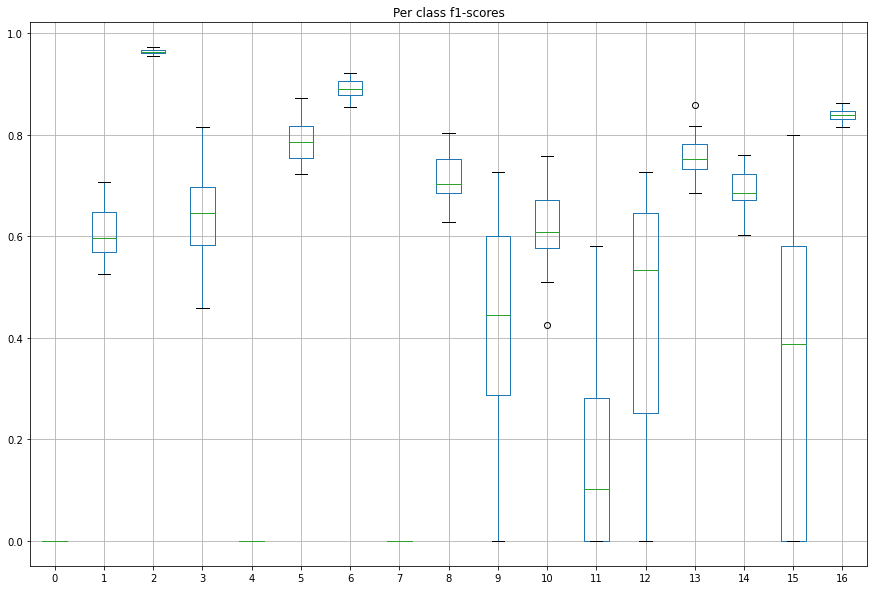

In [ ]:
# Visualize the per class f1-scores in a boxplot

# Filter the DataFrame
f1_scores = all_reports[all_reports['metric'] == 'f1-score']

# Drop non-numeric columns if any
#numeric_columns = f1_scores.select_dtypes(include=[np.number]).columns.tolist()
f1_scores = f1_scores[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']]

# Plot the boxplots
plt.figure(figsize=(15, 10))
f1_scores.boxplot()
plt.title('Per class f1-scores')
plt.show()

In [ ]:
# Calculate the mean and standard deviation of the f1-scores, precision, and recall
f1_scores = all_reports[all_reports['metric'] == 'f1-score']
precision_scores = all_reports[all_reports['metric'] == 'precision']
recall_scores = all_reports[all_reports['metric'] == 'recall']

mean_f1_scores = f1_scores.mean() * 100
std_f1_scores = f1_scores.std() * 100

mean_precision_scores = precision_scores.mean() * 100
std_precision_scores = precision_scores.std()

mean_recall_scores = recall_scores.mean() * 100
std_recall_scores = recall_scores.std() * 100

# Create a summary DataFrame
f1_scores_summary = mean_f1_scores.map('{:.2f}'.format) + " (" + std_f1_scores.map('{:.2f}'.format) + ")"
precision_scores_summary = mean_precision_scores.map('{:.2f}'.format) + " (" + std_precision_scores.map('{:.2f}'.format) + ")"
recall_scores_summary = mean_recall_scores.map('{:.2f}'.format) + " (" + std_recall_scores.map('{:.2f}'.format) + ")"

scores_summary = pd.DataFrame({'f1-score': f1_scores_summary,
                               'precision': precision_scores_summary,
                               'recall': recall_scores_summary})

scores_summary.to_csv('results/scores_summary.csv', sep=';', index=True)

In [ ]:
# Identify the index of the model that achieved the highest f1-score
all_reports[all_reports['metric'] == 'f1-score']['macro avg'].reset_index(drop=True).idxmax()

2

# **Considering an additional class with a threshold:**
When the maximum predicted probability is less than 80%, we consider the sample as no related to any Sustainable Development Goal



In [ ]:
# Load dataset and adjust labels
df = pd.read_csv('original_and_preprocessed.csv', sep=';', encoding='utf-8')
df['label'] = df['label'] - 1

In [ ]:
df.shape

(13789, 8)

In [ ]:
# This cell is responsible to find the exact same split that was used by the model with best metrics in the 30x runs

# The number of the run with the best metrics to load the respective mode weights
run_number = 2

X = df['processed_abstract_text'].reset_index(drop=True)
y = df['label'].reset_index(drop=True)

unique_labels = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=run_number, stratify=y, shuffle=True) # The random state is the run number

# Get unique labels in y_test and y
unique_test_labels = np.unique(y_test)

# Check if not all labels are represented in the test set
if set(unique_test_labels) != set(unique_labels):
    missing_labels = set(unique_labels) - set(unique_test_labels)
    # If not, add samples from the training set to the test set
    for missing_label in missing_labels:

        # Collect the indices of the samples to be moved
        missing_label_indices = y_train[y_train == missing_label].index.tolist()
        # Get the index of the first occurence of the missing label
        missing_label_index = missing_label_indices[0]

        # Add these samples to the test set
        X_test = pd.concat([X_test, X_train.loc[[missing_label_index]]], axis=0)
        y_test = pd.concat([y_test, y_train.loc[[missing_label_index]]], axis=0)

        # Remove these samples from the training set
        X_train = X_train.drop(missing_label_index)
        y_train = y_train.drop(missing_label_index)

# Initialize the model
bert_classifier = BertClassifier(training_args, id2label)

# Load the weights of the model that achieve best metrics
weights = torch.load(f'model/model_state_{run_number}.pt')
bert_classifier.model.load_state_dict(weights)
bert_classifier.model.eval() # Set model to evaluation mode

# Make predictions
pred_logits = bert_classifier.predict(X_test.to_list())
y_pred = np.argmax(pred_logits, axis=1)

# Get the classification report, rename the columns and save it to a CSV file
_classification_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, zero_division=0))

_classification_report.to_csv(f'results/best_classification_report.csv', sep=';', index=False, encoding='utf-8')

column_mapping = {str(old): str(old + 1) for old in range(0, 17)}
_classification_report = _classification_report.rename(columns=column_mapping)
_classification_report

Are the counts equal? True


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.wa

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,accuracy,macro avg,weighted avg
precision,0.0,0.642857,0.971741,0.684211,0.0,0.855263,0.871324,0.0,0.750000,0.666667,0.677419,0.700000,0.650000,0.758242,0.730159,0.833333,0.862069,0.903588,0.626664,0.900001
recall,0.0,0.610169,0.973616,0.812500,0.0,0.890411,0.908046,0.0,0.739130,0.571429,0.677419,0.388889,0.742857,0.862500,0.779661,0.454545,0.843882,0.903588,0.603239,0.903588
f1-score,0.0,0.626087,0.972678,0.742857,0.0,0.872483,0.889306,0.0,0.744526,0.615385,0.677419,0.500000,0.693333,0.807018,0.754098,0.588235,0.852878,0.903588,0.608018,0.901015
support,1.0,59.000000,1554.000000,16.000000,3.0,73.000000,261.000000,8.0,69.000000,7.000000,31.000000,18.000000,35.000000,80.000000,59.000000,11.000000,474.000000,0.903588,2759.000000,2759.000000


In [ ]:
# Apply the softmax function to the prediction logits to get the probabilities
prediction_probas = pd.DataFrame(pred_logits).apply(softmax, axis=1)
prediction_probas

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000008,0.000030,0.999730,0.000020,0.000019,0.000012,0.000028,0.000010,0.000014,0.000014,0.000011,0.000009,0.000004,0.000014,0.000006,0.000018,0.000053
1,0.000323,0.000123,0.000386,0.000213,0.000416,0.000592,0.000204,0.000390,0.000255,0.000458,0.000338,0.000448,0.000626,0.991174,0.002447,0.000258,0.001349
2,0.000787,0.001338,0.000390,0.000821,0.000901,0.001988,0.000723,0.000939,0.000531,0.000914,0.002300,0.001052,0.001870,0.003058,0.953165,0.002166,0.027058
3,0.000766,0.005400,0.002651,0.000827,0.000885,0.939815,0.009679,0.000693,0.001023,0.000315,0.002198,0.001893,0.002914,0.002341,0.002761,0.001155,0.024684
4,0.000012,0.000097,0.999503,0.000031,0.000026,0.000011,0.000045,0.000017,0.000020,0.000020,0.000014,0.000011,0.000005,0.000014,0.000010,0.000023,0.000141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,0.000007,0.000029,0.999754,0.000016,0.000017,0.000012,0.000023,0.000009,0.000015,0.000012,0.000011,0.000009,0.000004,0.000014,0.000006,0.000016,0.000046
2755,0.000312,0.004973,0.098571,0.000439,0.000664,0.000249,0.000376,0.000598,0.000562,0.000664,0.000442,0.000257,0.000206,0.000438,0.000881,0.000799,0.889569
2756,0.000038,0.000845,0.997743,0.000081,0.000076,0.000023,0.000135,0.000060,0.000072,0.000071,0.000044,0.000036,0.000026,0.000043,0.000129,0.000076,0.000502
2757,0.000007,0.000035,0.999740,0.000015,0.000017,0.000010,0.000031,0.000010,0.000015,0.000012,0.000010,0.000009,0.000004,0.000014,0.000006,0.000015,0.000050


In [ ]:
# This cell will filter the samples with a maximum predicted
# probability below a certain threshold and create a new classification report

# Ensure y_test and prediction_probas have the same indices
y_test = y_test.reset_index(drop=True)
prediction_probas = prediction_probas.reset_index(drop=True)

# Create a dataframe with the max probability value and the corresponding label
max_values = pd.DataFrame({
    'max_value': prediction_probas.max(axis=1), # maximum probabilities
    'prediction': y_pred, # predictions
})

cap = 0.8
number_max_value = len(max_values[max_values['max_value'] < cap])
filtered_samples = max_values[max_values['max_value'] < cap]

# Get the indices of the samples to exclude
exclude_indices = filtered_samples.index
predictions = pd.DataFrame(prediction_probas.values.argmax(axis=1))

# Create new Series without the excluded samples
filtered_pred = predictions.drop(exclude_indices)
filtered_true = y_test.drop(exclude_indices)
filtered_report = pd.DataFrame(classification_report(filtered_true, filtered_pred, output_dict=True, zero_division=0))

# Create a mapping from old column names to new ones
column_mapping = {str(old): str(old + 1) for old in range(0, 17)}

# Rename the columns
filtered_report.rename(columns=column_mapping, inplace=True)

In [ ]:
# Classification report of samples with max probability over 80%
filtered_report.to_csv('results/best_classification_report_80.csv', sep=';', index=False, encoding='utf-8')
filtered_report

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,accuracy,macro avg,weighted avg
precision,0.0,0.777778,0.975974,0.857143,0.0,0.915493,0.883019,0.0,0.810345,0.0,0.782609,0.0,0.78125,0.766667,0.785714,0.0,0.876993,0.92556,0.541940,0.919562
recall,0.0,0.673077,0.981711,0.800000,0.0,0.915493,0.924901,0.0,0.783333,0.0,0.666667,0.0,0.78125,0.873418,0.800000,0.0,0.873016,0.92556,0.533698,0.925560
f1-score,0.0,0.721649,0.978834,0.827586,0.0,0.915493,0.903475,0.0,0.796610,0.0,0.720000,0.0,0.78125,0.816568,0.792793,0.0,0.875000,0.92556,0.537015,0.922270
support,1.0,52.000000,1531.000000,15.000000,2.0,71.000000,253.000000,4.0,60.000000,2.0,27.000000,7.0,32.00000,79.000000,55.000000,1.0,441.000000,0.92556,2633.000000,2633.000000


In [ ]:
# Predictions where if the maximum predicted probability is 80% or more the prediction is set to corresponding SDG,
# otherwise it is considered as unrelated and set to 0
predictions_80 = prediction_probas.idxmax(axis=1).where(prediction_probas.max(axis=1) >= 0.8, 0)